## Graph Neural Networks

We'll be using **[pytorch-geometric](https://pytorch-geometric.readthedocs.io/en/latest/)** (PyG in short) to illustrate how Graph Neural Networks are implemented in practice.

We shortly introduce the fundamental concepts of PyG through self-contained examples.

At its core, PyG provides the following main features:
* Data Handling of Graphs
* Common Benchmark Datasets
* Mini-batches
* Data Transforms
* Learning Methods on Graphs
* Exercises


### Data Handling of Graphs
A single graph in PyG is described by an instance of `torch_geometric.data.Data`, which holds the following attributes by default:
* `data.x`: Node feature matrix with shape [num_nodes, num_node_features]
* `data.edge_index`: Graph connectivity in [COO format](https://pytorch.org/docs/stable/sparse.html#sparse-coo-docs) with shape [2, num_edges] and type `torch.long`
* `data.edge_attr`: Edge feature matrix with shape [num_edges, num_edge_features]
* `data.y`: Target to train against (may have arbitrary shape), e.g., node-level targets of shape [num_nodes, *] or graph-level targets of shape [1, *]
* `data.pos`: Node position matrix with shape [num_nodes, num_dimensions]

None of these attributes are required. In fact, the `Data` object is not even restricted to these attributes. We can, e.g., extend it by `data.face` to save the connectivity of triangles from a 3D mesh in a tensor with shape [3, num_faces] and type `torch.long`.

We show a simple example of an unweighted and undirected graph with three nodes and four edges. Each node contains exactly one feature:

In [ ]:
!pip install torch_geometric # install torch_geometric

In [ ]:
import torch
import torch_geometric
from torch_geometric.data import Data

edge_index = torch.tensor([[0, 1, 1, 2],
                           [1, 0, 2, 1]], dtype=torch.long)
x = torch.tensor([[-1], [0], [1]], dtype=torch.float)

data = Data(x=x, edge_index=edge_index)
print(data)

Note that `edge_index`, i.e. the tensor defining the source and target nodes of all edges, is **not** a list of index tuples. If you want to write your indices this way, you should transpose and call contiguous on it before passing them to the data constructor:

In [ ]:
import torch
from torch_geometric.data import Data

edge_index = torch.tensor([[0, 1],
                           [1, 0],
                           [1, 2],
                           [2, 1]], dtype=torch.long)
x = torch.tensor([[-1], [0], [1]], dtype=torch.float)

data = Data(x=x, edge_index=edge_index.t().contiguous())
print(data)

Although the graph has only two edges, we need to define four index tuples to account for both directions of a edge.

Note that it is necessary that the elements in `edge_index` only hold indices in the range { 0, ..., num_nodes - 1}. This is needed as we want our final data representation to be as compact as possible, e.g., we want to index the source and destination node features of the first edge (0, 1) via x[0] and x[1], respectively. You can always check that your final Data objects fulfill these requirements by running `validate()`:

In [ ]:
data.validate(raise_on_error=True)

Besides holding a number of node-level, edge-level or graph-level attributes, `Data` provides a number of useful utility functions, e.g.:

In [ ]:
print(data.keys())

In [ ]:
print(data['x'])

In [ ]:
for key, item in data:
    print(f'{key} found in data')

In [ ]:
data.num_nodes

In [ ]:
data.num_edges

In [ ]:
data.num_node_features

In [ ]:
data.has_isolated_nodes()

In [ ]:
data.has_self_loops()

In [ ]:
data.is_directed()

### Mini-batches
Neural networks are usually trained in a batch-wise fashion. PyG achieves parallelization over a mini-batch by creating sparse block diagonal adjacency matrices (defined by edge_index) and concatenating feature and target matrices in the node dimension. This composition allows differing number of nodes and edges over examples in one batch:

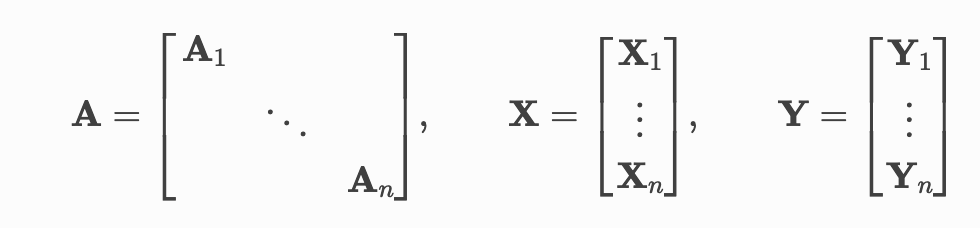

PyG contains its own `torch_geometric.loader.DataLoader`, which already takes care of this concatenation process. Let's learn about it in an example:

In [ ]:
from torch_geometric.datasets import TUDataset
from torch_geometric.loader import DataLoader

dataset = TUDataset(root='/tmp/ENZYMES', name='ENZYMES', use_node_attr=True)
loader = DataLoader(dataset, batch_size=32, shuffle=True)

for batch in loader:
    print(batch)
    print(batch.num_graphs)

`torch_geometric.data.Batch` inherits from `torch_geometric.data.Data` and contains an additional attribute called batch.

batch is a column vector which maps each node to its respective graph in the batch:
\begin{equation}
\text{batch} = {\begin{bmatrix} 0 & \cdots & 0 & 1 & \cdots & n - 2 & n -1 & \cdots & n - 1 \end{bmatrix}}^{\top}
\end{equation}
You can use it to, e.g., average node features in the node dimension for each graph individually:

In [ ]:
from torch_geometric.utils import scatter
from torch_geometric.datasets import TUDataset
from torch_geometric.loader import DataLoader

dataset = TUDataset(root='/tmp/ENZYMES', name='ENZYMES', use_node_attr=True)
loader = DataLoader(dataset, batch_size=32, shuffle=True)

for data in loader:
    x = scatter(data.x, data.batch, dim=0, reduce='mean')
    print(x.size())

You can learn more about the internal batching procedure of PyG, e.g., how to modify its behavior, [here](https://pytorch-geometric.readthedocs.io/en/latest/advanced/batching.html). For documentation of scatter operations, we refer the interested reader to the torch_scatter [documentation](https://pytorch-scatter.readthedocs.io/).

### Common Benchmark Datasets
PyG contains a large number of common benchmark datasets, e.g., all Planetoid datasets (Cora, Citeseer, Pubmed), all graph classification datasets from [TUDatasets](https://chrsmrrs.github.io/datasets/) and their [cleaned versions](https://github.com/nd7141/graph_datasets), the QM7 and QM9 dataset, and a handful of 3D mesh/point cloud datasets like FAUST, ModelNet10/40 and ShapeNet.

Initializing a dataset is straightforward. An initialization of a dataset will automatically download its raw files and process them to the previously described Data format. E.g., to load the ENZYMES dataset (consisting of 600 graphs within 6 classes), type:

In [ ]:
from torch_geometric.datasets import TUDataset

dataset = TUDataset(root='/tmp/ENZYMES', name='ENZYMES')
print('Dataset length: ', len(dataset))
print('Number of classes: ', dataset.num_classes)
print('Number of node features: ', dataset.num_node_features)

We now have access to all 600 graphs in the dataset:

In [ ]:
print(dataset[0])
print('Undirected graph? ', data.is_undirected())

We can see that the first graph in the dataset contains 37 nodes, each one having 3 features. There are 168/2 = 84 undirected edges and the graph is assigned to exactly one class. In addition, the data object is holding exactly one graph-level target.

We can even use slices, long or bool tensors to split the dataset. E.g., to create a 90/10 train/test split, type:

In [ ]:
train_dataset = dataset[:540]
test_dataset = dataset[540:]

If you are unsure whether the dataset is already shuffled before you split, you can randomly permute it by running:

In [ ]:
dataset = dataset.shuffle()

This is equivalent of doing:

In [ ]:
perm = torch.randperm(len(dataset))
dataset = dataset[perm]

Let's try another one! Let's download Cora, the standard benchmark dataset for semi-supervised graph node classification:

In [ ]:
from torch_geometric.datasets import Planetoid

dataset = Planetoid(root='/tmp/Cora', name='Cora')
print('Dataset length: ', len(dataset))
print('Number of classes: ', dataset.num_classes)
print('Number of node features: ', dataset.num_node_features)

Here, the dataset contains only a single, undirected citation graph:

In [ ]:
data = dataset[0]
print('Undirected graph? ', data.is_undirected())
print('Number of train points: ', data.train_mask.sum().item())
print('Nubmer of validation points: ', data.val_mask.sum().item())
print('Number of test points: ', data.test_mask.sum().item())

This time, the `Data` objects holds a label for each node, and additional node-level attributes: `train_mask`, `val_mask` and `test_mask`, where
* `train_mask` denotes against which nodes to train (140 nodes),
* `val_mask` denotes which nodes to use for validation, e.g., to perform early stopping (500 nodes),
* `test_mask` denotes against which nodes to test (1000 nodes).

### Learning Methods on Graphs
After learning about the basics in PyG, it's time to implement our first graph neural network!

We will use a simple Graph Convolutional Networks (GCN) layer and replicate the experiments on the Cora citation dataset. We first need to load the Cora dataset:

In [ ]:
from torch_geometric.datasets import Planetoid

dataset = Planetoid(root='/tmp/Cora', name='Cora')

Now let's implement a two-layer GCN:

In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(dataset.num_node_features, 16)
        self.conv2 = GCNConv(16, dataset.num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim=1)

The constructor defines two GCNConv layers which get called in the forward pass of our network. Note that the non-linearity is not integrated in the conv calls and hence needs to be applied afterwards (something which is consistent across all operators in PyG). Here, we chose to use ReLU as our intermediate non-linearity and finally output a softmax distribution over the number of classes. Let's train this model on the training nodes for 200 epochs:

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN().to(device)
data = dataset[0].to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

model.train()
for epoch in range(200):
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

Finally, we can evaluate our model on the test nodes:

In [ ]:
model.eval()
pred = model(data).argmax(dim=1)
correct = (pred[data.test_mask] == data.y[data.test_mask]).sum()
acc = int(correct) / int(data.test_mask.sum())
print(f'Accuracy: {acc:.4f}')